In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.augmentation import DonutShift, PaddedShift

In [12]:
class DonutConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.dilation = dilation
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=0, dilation=dilation)

        self.pad_size = ((kernel_size - 1) * dilation) // 2

    def forward(self, x):
        x = torch.cat([x, x[:, :, :, :self.pad_size]], dim=3)
        x = torch.cat([x[:, :, :, -self.pad_size:], x], dim=3)
        x = torch.cat([x, x[:, :, :self.pad_size, :]], dim=2)
        x = torch.cat([x[:, :, -self.pad_size:, :], x], dim=2)
        return self.conv(x)

class DonutCNN(nn.Module):
    def __init__(self, img_size=28, num_classes=10):
        super().__init__()

        self.img_size = img_size
        self.num_classes = num_classes

        self.conv1 = DonutConv2d(1, 6, kernel_size=5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = DonutConv2d(6, 16, kernel_size=5)
        self.fc1 = nn.Linear(16 * ((img_size // 4) ** 2), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * ((self.img_size // 4) ** 2))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class CNN(nn.Module):
    def __init__(self, img_size=28, num_classes=10):
        super().__init__()

        self.img_size = img_size
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding='same') 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding='same')
        self.fc1 = nn.Linear(16 * ((img_size // 4) ** 2), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * ((self.img_size // 4) ** 2))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
def train(net, trainloader, optimizer, criterion, epochs=5, device='cpu'):
    net.train()
    for _ in range(epochs):
        for data in trainloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

def evaluate(net, testloader, device='cpu'):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [14]:
def train_donut_cnn(max_shift=0):
    train_transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5], std=[0.5]),
        DonutShift(max_shift, max_shift),
    ])
    test_transform = v2.Compose([    
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])
    trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
    testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

    net = DonutCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)

    train(net, trainloader, optimizer, criterion, device=device)
    return evaluate(net, testloader, device=device)

def train_cnn(max_shift=0):
    train_transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5], std=[0.5]),
        PaddedShift(max_shift, max_shift),
    ])
    test_transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5], std=[0.5]),
    ])
    trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=train_transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
    testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=test_transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

    net = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net.to(device)

    train(net, trainloader, optimizer, criterion, device=device)
    return evaluate(net, testloader, device=device)

In [15]:
donut_accuracies = []
accuracies = []

for max_shift in range(0, 28):
    donut_accuracy = train_donut_cnn(max_shift)
    accuracy = train_cnn(max_shift)
    donut_accuracies.append(donut_accuracy)
    accuracies.append(accuracy)
    print(f'max_shift: {max_shift}, donut_accuracy: {donut_accuracy}, accuracy: {accuracy}')

max_shift: 0, donut_accuracy: 0.9823, accuracy: 0.9824
max_shift: 1, donut_accuracy: 0.9797, accuracy: 0.9858
max_shift: 2, donut_accuracy: 0.979, accuracy: 0.98
max_shift: 3, donut_accuracy: 0.9732, accuracy: 0.982
max_shift: 4, donut_accuracy: 0.9601, accuracy: 0.9757
max_shift: 5, donut_accuracy: 0.9653, accuracy: 0.9749
max_shift: 6, donut_accuracy: 0.959, accuracy: 0.9648
max_shift: 7, donut_accuracy: 0.9481, accuracy: 0.96
max_shift: 8, donut_accuracy: 0.9438, accuracy: 0.953
max_shift: 9, donut_accuracy: 0.9346, accuracy: 0.9522
max_shift: 10, donut_accuracy: 0.9225, accuracy: 0.9319
max_shift: 11, donut_accuracy: 0.915, accuracy: 0.9289
max_shift: 12, donut_accuracy: 0.9152, accuracy: 0.8827
max_shift: 13, donut_accuracy: 0.9051, accuracy: 0.8579
max_shift: 14, donut_accuracy: 0.902, accuracy: 0.7987
max_shift: 15, donut_accuracy: 0.9013, accuracy: 0.867
max_shift: 16, donut_accuracy: 0.8937, accuracy: 0.7517
max_shift: 17, donut_accuracy: 0.8899, accuracy: 0.7858
max_shift: 18

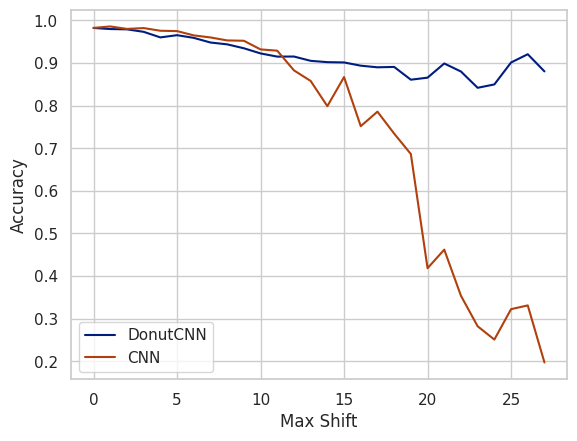

In [20]:
sns.set_theme('notebook', 'whitegrid', 'dark')

plt.plot(donut_accuracies, label='DonutCNN')
plt.plot(accuracies, label='CNN')
plt.legend()
plt.xlabel('Max Shift')
plt.ylabel('Accuracy')
plt.show()